In [118]:
# %initialize.m
# %% Initialize Parameters and special indices

import numpy as np 
import matplotlib.pyplot as plt

# global dt, Nb, N, h, rho, mu, ip, im, a;
# global kp, km, dtheta, K;

class IBM2(object):
  
    def __init__(self, N=64, L=1., rho=1., mu=.01, Nb=None, K=1., dt=.01):
        self._L = L 
        self.N = N                         
        self.rho = rho  # Fluid density
        self.mu = mu    # viscosity 
        
        self.Nb = Nb or np.ceil(np.pi*(L)/(self.h)) 
        self.K = K      # Elastic stiffness
    

        self.dt = dt                    # Time step
    #     tmax=1 # Run until time
    #     clockmax=np.ceil(tmax/dt)
        
        self.init_a()
        self.initialize()
    
  #### Fluid domain properties ####
    @property  # Number of grid cells
    def N(self): return self._N
    
    @N.setter
    def N(self, N):
        self._N = int(N)
        self._h = self.L/(self.N+1)
        self.ip = np.arange(N)+1   # Grid index shifted left
        self.ip[-1] = 0
        self.im = np.arange(N)-1   # Grid index shifted right
    
    @property  # Box size
    def L(self): return self._L
    
    @L.setter
    def L(self, L):
        self._L = float(L)
        self._h = self.L/self.N

    @property  # Grid spacing
    def h(self): return self._h
        
        
  #### Immersed Boundary domain roperties ####    
    @property  # Number of IB points
    def Nb(self): return self._Nb
    
    @Nb.setter 
    def Nb(self, Nb):
        self._Nb = int(Nb)
        self._dtheta = 2*np.pi/Nb        
        self.kp = np.arange(self.Nb)+1       # IB index shifted left
        self.kp[-1] = 0
        self.km = np.arange(self.Nb)-1       # IB index shifted right
    
    @property  # IB point spacing
    def dtheta(self): return self._dtheta
    
    def initialize(self):  ## Initialize boundary and velocity
        self.t = 0.        ## Current time
        N, L, ip, im, = self.N, self.L, self.ip, self.im

        theta = self.dtheta*np.arange(self.Nb)
        self.X = (L/2) + (L/4)*np.array([np.cos(theta), np.sin(theta)])
        self.X = np.array(self.X, dtype=np.float64)
        u = np.zeros([2,N,N]);
        j = np.arange(N)
        u[1]+=np.sin(2*np.pi*self.h*j/L)
#         u[:,:,1]+=np.sin(2*np.pi*j*self.h/L)[:, np.newaxis];
        self.u = u

        # %% Initialize animation
        vorticity=(u[1,ip,:]-u[1,im,:]-u[0,:,ip]+u[0,:,im])/(2*self.h);
        dvorticity=(np.max(vorticity)-np.min(vorticity))/5;
        dvorticity = max(dvorticity, 0.1)  ## Catch error on 0 (or uniform) vorticity
        # values= (-10*dvorticity):dvorticity:(10*dvorticity); % Get vorticity contours
        values= np.arange(-10*dvorticity, 10*dvorticity, dvorticity); # Get vorticity contours
        valminmax=[min(values),max(values)];
    

    #     set(gcf,'double','on')
        plt.figure(figsize=(8,8))
#         plt.contour(xgrid,ygrid,vorticity,values)
        plt.imshow(u[1])
        plt.show()
        plt.figure(figsize=(8,8))
        plt.scatter(self.X[0],self.X[1])
        plt.xlim([0,L])
        plt.ylim([0,L])
        plt.show()


    def init_a(self):
        N = self.N
        a = np.zeros([2,2,N,N])#, dtype=np.complex128)
        a[0, 0] = 1
        a[1, 1] = 1

        for m1 in range(N):
            for m2 in range(N):
                if not ((m1==0 or m1==N/2) and (m2==0 or m2==N/2)):
                    t=(2*np.pi/N)*np.array([m1, m2]);
                    s=np.sin(t);

                    #### Note matrix multiplication might matter here
                    ss=np.outer(s, s)/np.inner(s, s)

                    #     a(m1+1,m2+1,:,:)=a(m1+1,m2+1,:,:)-(s*s')/(s'*s)
                    a[0,0,m1,m2]-=ss[0,0]
                    a[0,1,m1,m2]-=ss[0,1]
                    a[1,0,m1,m2]-=ss[1,0]
                    a[1,1,m1,m2]-=ss[1,1]

        for m1 in range(N):
            for m2 in range(N):
                t=(np.pi/N)*np.array([m1, m2]);
                s=np.sin(t);
                a[:,:,m1,m2] /= (1+(self.dt/2)*(self.mu/self.rho)*(4/(self.h**2))*(np.outer(s, s)));
        self.a = a

   
    
  
    
    def phi(self, r):
        w = np.zeros(4)
        q=np.sqrt(1+4*r*(1-r))
        w[3]=(1+2*r-q)/8
        w[2]=(1+2*r+q)/8
        w[1]=(3-2*r+q)/8
        w[0]=(3-2*r-q)/8
        return w

    def interp(self, u, X):
        N, Nb, h = self.N, self.Nb, self.h
        W = np.zeros([N, N])

        U=np.zeros([2,Nb])
        s=X/float(h)
        i=np.array(np.floor(s), dtype=int)
        r=s-i
#         print('r')
#         print(r)
#         print('---------')
#         w=self.phi1(r[0])*self.phi2(r[1])
        for k in range(Nb):
            w = np.outer(self.phi(r[1, k]), self.phi(r[0, k]))
#             print('w{}'.format(k))
#             print(w)
          
#             w = np.outer(self.phi(r[0, k]), np.flip(self.phi(r[1, k])))
            i1 = np.arange(i[0,k]-1, i[0,k]+3)%N
            i2 = np.arange(i[1,k]-1, i[1,k]+3)%N
            ii = np.meshgrid(i2, i1)
#             print()
#             print(ii)
#             print()
#             print(i1)
#             print(i2)
            
#             print('--------')
#             print('u')
#             print(u[0][ii])
#             print(u[1][ii])
#             print()
#             W[ii] += w[k]
#             U[0,k]=np.sum(w[k]*u[0][ii]);
#             U[1,k]=np.sum(w[k]*u[1][ii]);
            W[ii] += w
            U[0,k]=np.sum(w*u[0][ii]);
            U[1,k]=np.sum(w*u[1][ii]);
#         print('after interp:')
        
#         plt.imshow(np.transpose(W))
#         plt.colorbar()
#         plt.scatter(X[0]/h, X[1]/h)
#         plt.show()
#         print(np.mean(abs(U)))
#         print('U')
#         print(U)
#         print()
#         print()
        return U
    
    def vec_spread(self, F, X):
        N, Nb, h = self.N, self.Nb, self.h
        W = np.zeros([N, N])
        
        c=self.dtheta/h**2;
        f=np.zeros([2,N,N]);
        s=X/float(h)
        i=np.array(np.floor(s), dtype=int)
        r=s-i
#         print('r')
#         print(i)
#         print('---------')
#         w=self.phi1(r[0])*self.phi2(r[1]);
#         print(np.shape(w))
        for k in range(Nb):
#             w = np.outer(self.phi(r[0, k]), np.flip(self.phi(r[1, k])))
            w = np.outer(self.phi(r[1, k]), self.phi(r[0, k]))
            i1 = np.arange(i[0,k]-1, i[0,k]+3)%N
            i2 = np.arange(i[1,k]-1, i[1,k]+3)%N
            ii = np.meshgrid(i2, i1)
    #         w = permute(w, [1,3,4,2]); 
#             print('w{}'.format(k))
#             print(w)
        
            f[0][ii]+=(c*F[0,k])*w #Spread force to fluid
            f[1][ii]+=(c*F[1,k])*w
            W[ii] += w#[k]
#             print('ff{}'.format(k))
#             print(f[0][ii])
#             print(f[1][ii])
#             print()
#             print()
#         print('after spread:')
#         plt.imshow(np.transpose(W))
#         plt.colorbar()
#         plt.scatter(X[0]/h, X[1]/h)
#         plt.show()
        return f 
    
    
    def Force(self, X):
        kp, km, dtheta, K = self.kp, self.km, self.dtheta, self.K
        # elastic stretching force
#         return K*(X[:,kp]+X[:,km]-2*X)/(dtheta**2);
        C = K/dtheta
        D = (X[:,kp]+X[:,km]-2*X)/dtheta
        return C*D
#         return K*(X[:,kp]+X[:,km]-2*X)/(dtheta**2);
    
    
    # Time step the fluid
    def fluid(self, u, ff):
        
        uu = np.zeros(np.shape(u))
        uuu = np.zeros(np.shape(u))
        
        a, dt, rho, mu = self.a, self.dt, self.rho, self.mu
        w=u-(dt/2)*self.skew(u)+(dt/(2*rho))*ff; # Get RHS
        w=np.fft.fft(w, axis=0)
        w=np.fft.fft(w, axis=1)
        uu[0]=a[0,0]*(w[0]+0j)+a[0,1]*(w[1]+0j); # Solve for LHS
        uu[1]=a[1,0]*(w[0]+0j)+a[1,1]*(w[1]+0j);
        uu=np.fft.ifft(uu,axis=1);
        uu=np.fft.ifft(uu,axis=0).real; #Get u at midpoint in time

        
        
        w=u-dt*self.skew(uu)+(dt/rho)*ff+(dt/2)*(mu/rho)*self.laplacian(u);# Get RHS
        w=np.fft.fft(w, axis=0)
        w=np.fft.fft(w, axis=1)
        uuu[0]=a[0,0]*w[0]+a[0,1]*w[1];# Solve for LHS
        uuu[1]=a[1,0]*w[0]+a[1,1]*w[1];
       
        uuu=np.fft.ifft(uuu,axis=1);
        uuu=np.fft.ifft(uuu,axis=0).real; # Get u at next timestep
        return uuu, uu

    # Second order centered Laplacian
    def laplacian(self, u): 
        im, ip, h = self.ip, self.im, self.h
        w=(u[:,ip,:]+u[:,im,:]+u[:,:,ip]+u[:,:,im]-4*u)/(h**2);
        return w
    #     % im = [N,1:(N-1)] = circular version of i-1
    #     % ip = [2:N,1]     = circular version of i+1
    #     % N  = number of points in each space direction
    
    
    def skew(self, u):
        w=1.*u; #note that this is done only to make w the same size as u
        w[0]=self.sk(u,u[0]);
        w[1]=self.sk(u,u[1]);
        return w
    
    
    def sk(self, u, g):
        ip, im, h = self.ip, self.im, self.h
        return ((u[0,ip,:]+u[0])*g[ip,:]
                -(u[0,im,:]+u[0])*g[im,:]
                +(u[1,:,ip]+u[1])*g[:,ip]
                -(u[1,:,im]+u[1])*g[:,im])/(4*h);
    
    
    
     ## Run until time t
    def run(self, t):
        while self.t < t:         #for clock=1:clockmax
            self.iterate()

    def iterate(self):
        dt = self.dt
        ## Run simulation
        self.t += dt
        XX=self.X+(dt/2)*self.interp(self.u,self.X) # Euler step to midpoint
#         print('XX')
#         print(XX)
#         print()
#         print()
        ff=self.vec_spread(self.Force(XX),XX) # Force at midpoint
        u,uu=self.fluid(self.u,ff) # Step Fluid Velocity
        self.X+=dt*self.interp(uu,XX) # full step using midpoint velocity
#         print('X')
#         print(self.X)
#         print()
#         print()
#         print(np.mean(abs(dt*self.interp(uu,XX))))
        self.u = u

        #animation:        
#         ip, im = self.ip, self.im
#         vorticity=(u[1,ip,:]-u[1,im,:]-u[0,:,ip]+u[0,:,im])/(2*self.h);
# #         plt.contour(xgrid,ygrid,vorticity,values)
#         plt.imshow(vorticity)
#         plt.colorbar()
#         plt.streamplot(*np.meshgrid(np.arange(self.N), np.arange(self.N)), self.u[0], self.u[1])
#         plt.show()
        plt.scatter(self.X[0],self.X[1])
        plt.xlim([0,self.L])
        plt.ylim([0,self.L])

    #     caxis(valminmax)
    #     axis equal
    #     axis manual
        plt.show()
#         self.u[0, :] = 0.5


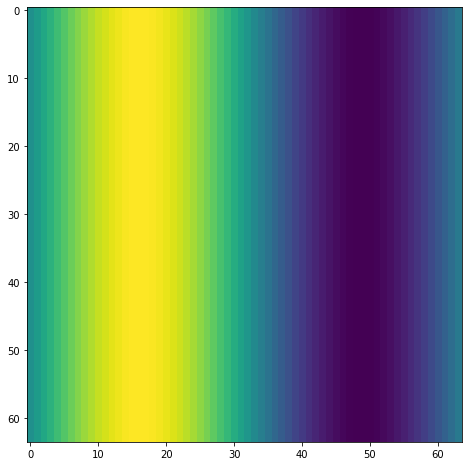

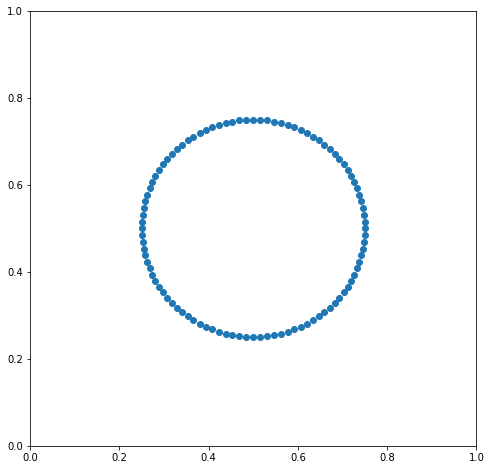

<ipython-input-118-ac24aa9b64f1>:178: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  W[ii] += w
<ipython-input-118-ac24aa9b64f1>:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  U[0,k]=np.sum(w*u[0][ii]);
<ipython-input-118-ac24aa9b64f1>:180: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  U[1,k]=np.sum(w*u[1][ii]);

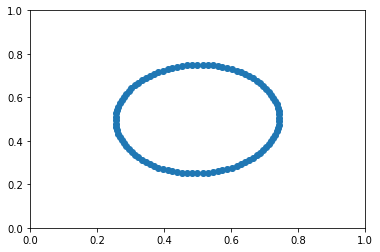

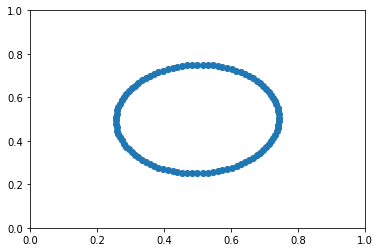

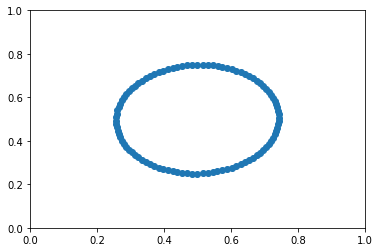

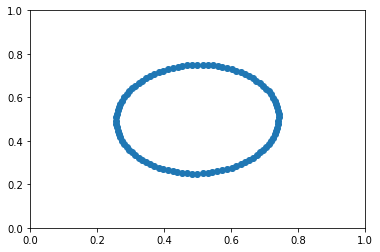

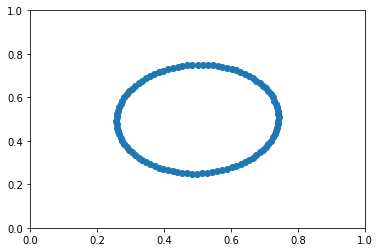

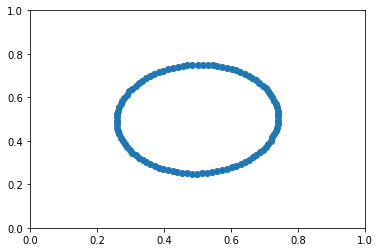

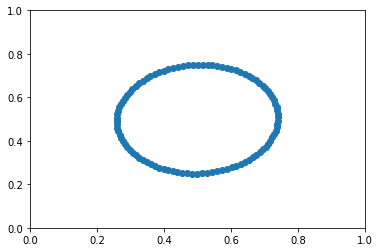

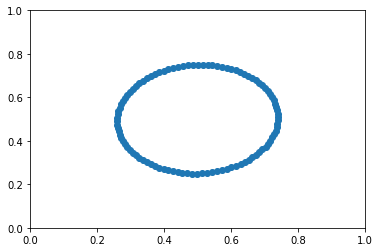

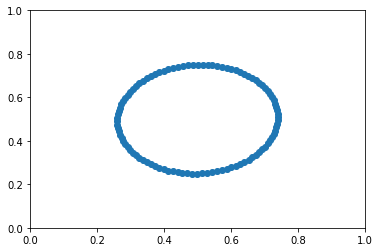

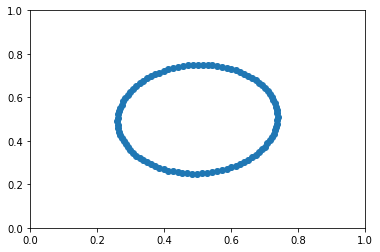

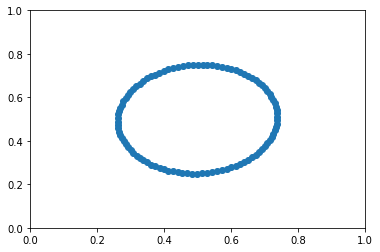

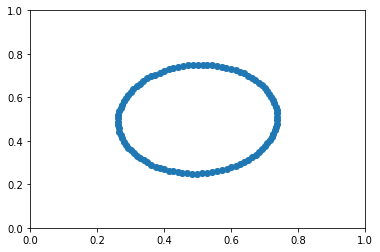

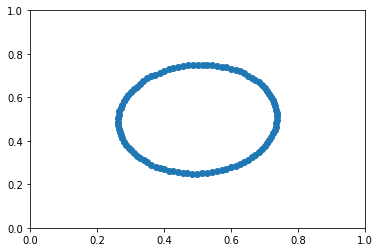

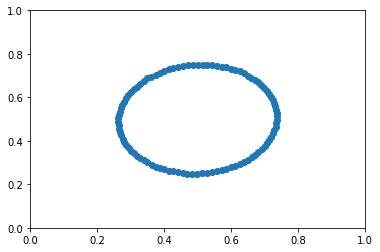

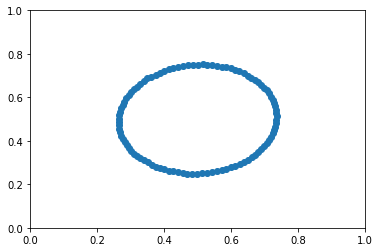

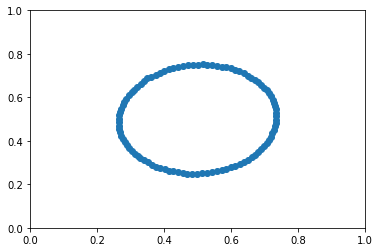

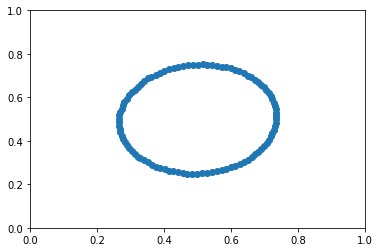

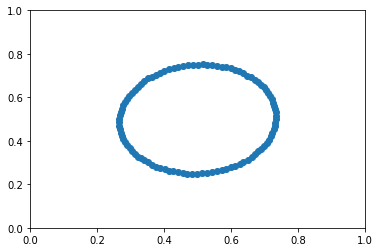

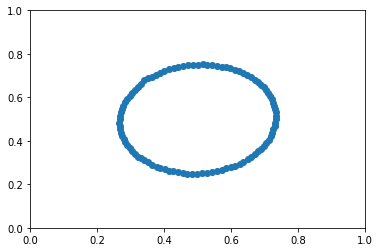

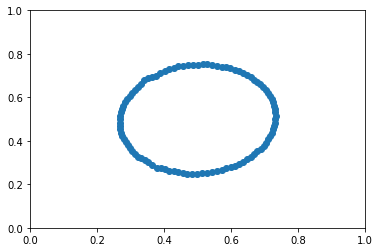

In [119]:
# sim = IBM2(N=63, Nb=5, dt=.01)
sim = IBM2(N=64, Nb=100)
# r = np.linspace(-5., 5., 100)
# plt.imshow(sim.vec_phi1(r))
# plt.colorbar()
# plt.show()
for i in range(20):
    sim.iterate()
# sim.run(.5)

In [116]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

In [36]:
a = np.arange(10)
print(np.flip(a))

[9 8 7 6 5 4 3 2 1 0]
